# Optimize the set of samples for limited learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    
C = Const()

In [3]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [4]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    
    return model

model = build_model()
#model.summary()

[[ 1  3  5  7  2  0 13 15 17  4]
 [21  6 16 10  9 11 18 29 31 19]
 [34  8 25 12 20 35 32 38 41 22]
 [37 14 28 27 26 47 36 42 46 33]
 [51 23 76 30 53 65 39 52 55 43]]


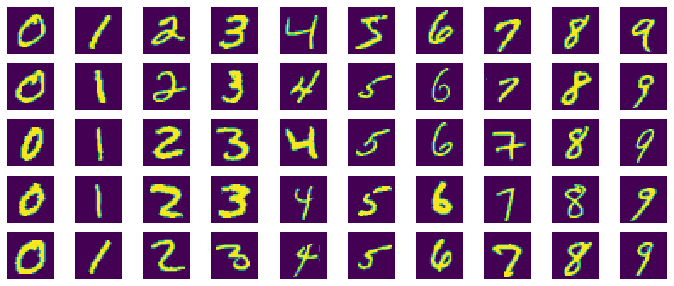

In [13]:
# Pick a few complete sets of digits

nrows = 5
hist = [0]*10
indices = np.zeros((nrows, 10), dtype=int)
plt.figure(figsize=(12,5))
i = 0
while min(hist) < nrows:
    label = np.argmax(ytrain[i])
    if hist[label]<nrows:
        plt.subplot(nrows, 10, 1+label+hist[label]*10)
        plt.imshow(xtrain[i,:,:,0]);
        #plt.title(label)
        plt.axis('off')
        indices[hist[label], label] = i
        hist[label] += 1
    i += 1
    
print(indices)

In [14]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')

In [15]:
# Create a new model, and train it on 10 samples only 
def test_subset(indices):
    model2 = build_model()

    hist = model2.fit(xtrain[indices], ytrain[indices],
                      batch_size=1024,
                      epochs=40,
                      verbose=0,
                      validation_data=(xtest, ytest))

    score = model2.evaluate(xtest, ytest, verbose=0)
    return score[1] # Accuracy
    
best_val = test_subset(indices[0,:])
print(best_val)

0.5573


New worst  : 0.588699996471405, with indices [ 1  3  5  7  2  0 13 15 17  4]
New worst  : 0.5160999894142151, with indices [ 1  3  5  7  2  0 18 15 17  4]
New worst  : 0.4722000062465668, with indices [ 1  3  5  7  2  0 18 15 17 19]
New worst  : 0.4645000100135803, with indices [ 1 23  5  7  2  0 18 15 17 19]
New worst  : 0.43880000710487366, with indices [ 1 24  5  7  2  0 18 15 17 19]
New worst  : 0.3930000066757202, with indices [ 1 24  5  7 26  0 18 15 17 19]
New worst  : 0.3580000102519989, with indices [34 24  5  7 26  0 18 15 17 19]
New worst  : 0.3472999930381775, with indices [34 24  5  7 26  0 18 38 17 19]
New worst  : 0.34360000491142273, with indices [34 24  5  7 53  0 18 38 17 19]
New worst  : 0.3379000127315521, with indices [34 24  5  7 53  0 18 38 17 54]
New worst  : 0.3276999890804291, with indices [34 24  5  7 61  0 18 38 17 54]
New worst  : 0.3061000108718872, with indices [ 34  24   5   7  61   0 106  38  17  54]
New worst  : 0.29330000281333923, with indices [ 34  

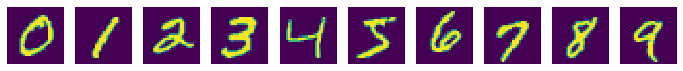

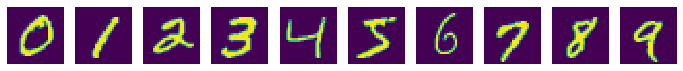

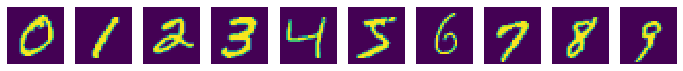

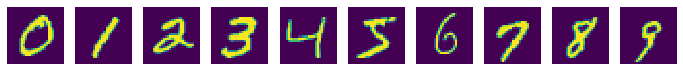

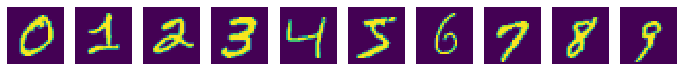

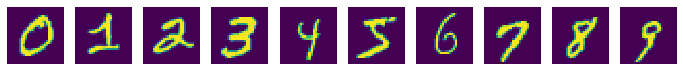

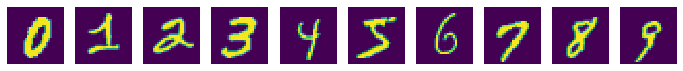

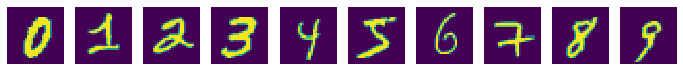

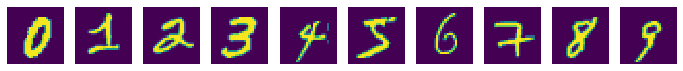

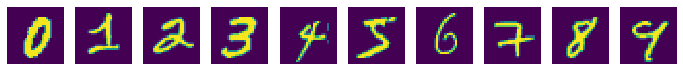

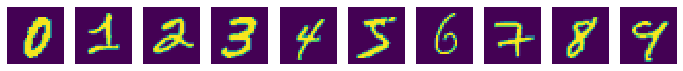

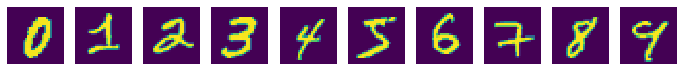

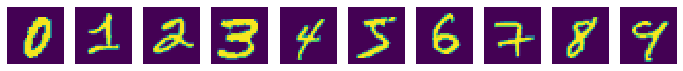

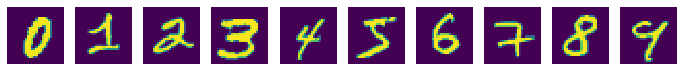

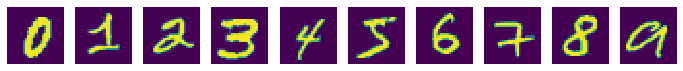

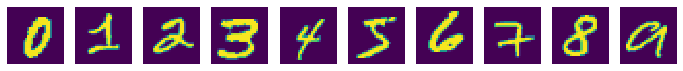

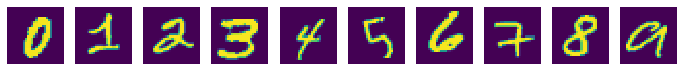

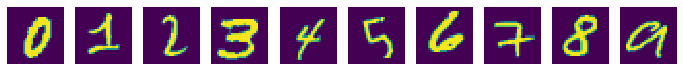

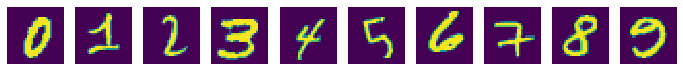

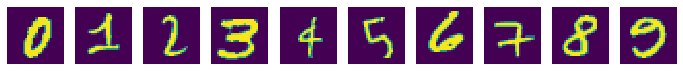

In [16]:
# Find most representative data

n_improvements = 20
ind = indices[0,:] # Starting value
i = max(ind)
count = 0
ind_best = []
best_val = 0
while count < n_improvements:
    label = np.argmax(ytrain[i])
    ind[label] = i
    new_val = test_subset(ind)
    if new_val < best_val or best_val==0:
        count += 1
        best_val = new_val
        ind_best = ind.copy()
        print(f"New worst  : {best_val}, with indices {ind}")
        plt.figure(figsize=(12,2))
        for k in range(10):
            plt.subplot(1, 10, k+1)
            plt.imshow(xtrain[ind[k],:,:,0]);
            plt.axis('off')
    else:
        # print(f"Bad result: {new_val}, with index {i} (label {label})")
        ind = ind_best.copy() # Reset to previous best
    i += 1